# Image Processing Project

## Uploading data

In this step, I downloaded and unzipped the Dogs vs. Cats dataset.

This is required for the `ImageDataGenerator.flow_from_directory()` function, which loads images in batches and assigns labels based on subfolder names.


## Visualize Samples and Load Data 

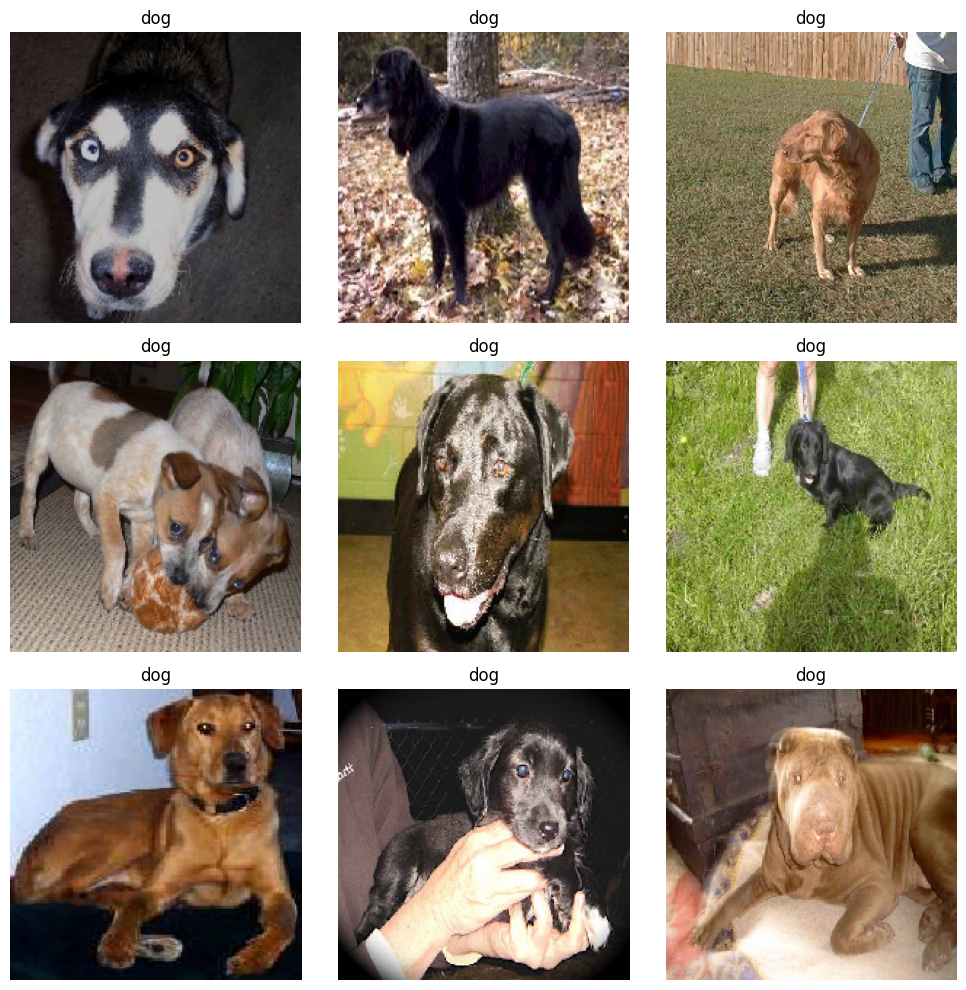

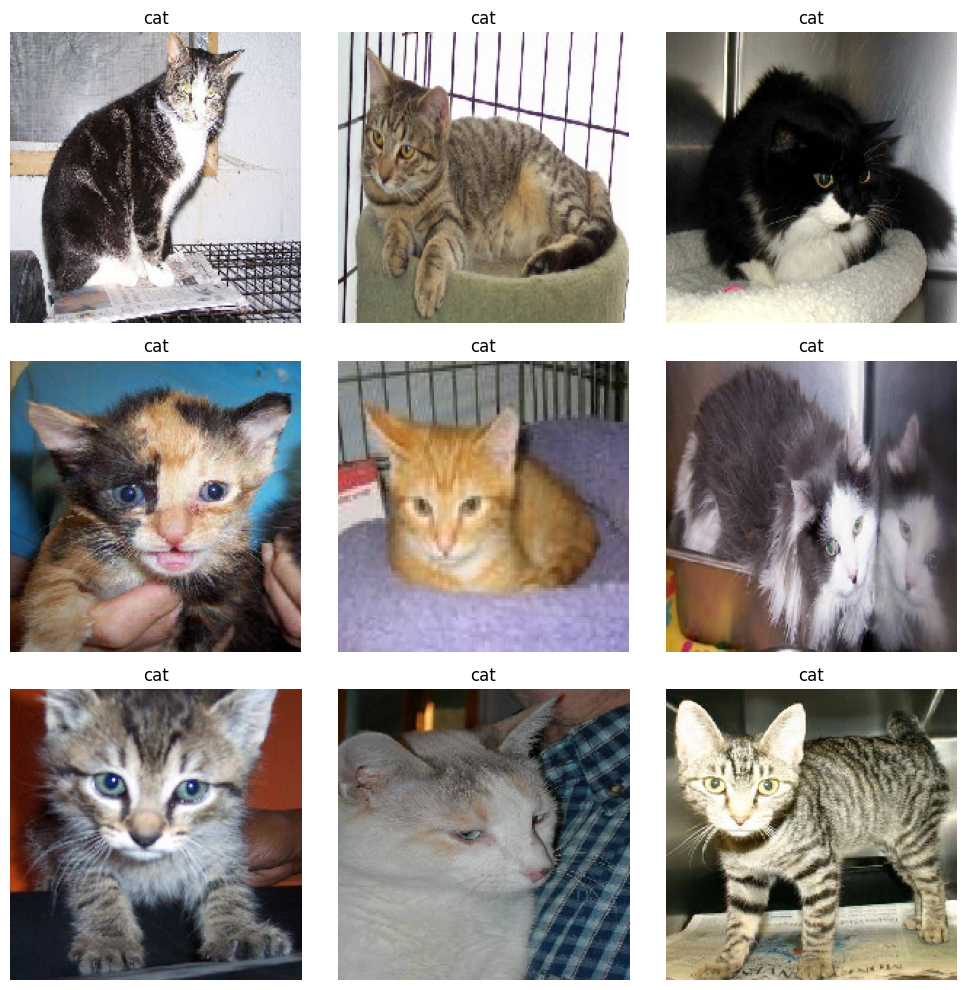

In [10]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
import os

# Define base path for Codespace
base_path = "/workspaces/ginotomasd-imageclassifierproject/data"

def plot_images(folder, label, n=9):
    images = os.listdir(os.path.join(folder, label))[:n]
    plt.figure(figsize=(10, 10))
    for i, image in enumerate(images):
        img_path = os.path.join(folder, label, image)
        img = load_img(img_path, target_size=(200, 200))
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show first 9 dogs and cats from train set
plot_images(f"{base_path}/train_split", "dog")
plot_images(f"{base_path}/train_split", "cat")

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Use smaller images and split for faster training
IMAGE_SIZE = (64, 64)
BATCH_SIZE = 32
base_path = "/workspaces/ginotomasd-imageclassifierproject/data"

# Generators with validation split
train_gen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_loader = train_gen.flow_from_directory(
    directory=os.path.join(base_path, "train_split"),
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    subset="training",
    shuffle=True
)

val_loader = train_gen.flow_from_directory(
    directory=os.path.join(base_path, "train_split"),
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    subset="validation",
    shuffle=True
)


Found 18000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## Build the CNN Model (VGG-style architecture)

In this step, I’ll build a convolutional neural network inspired by the VGG16 architecture, which is a classic and powerful CNN model. It uses stacked 3x3 convolutions with ReLU activation and MaxPooling layers to extract visual features from the images.

The model ends with Dense layers to perform binary classification (cat or dog) based on the extracted features.


In [12]:
# Step 3: Build the CNN model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout

# Initialize a lightweight VGG-style CNN
model = Sequential()

# Convolutional block 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))

# Convolutional block 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# Convolutional block 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# Fully connected layers (adjusted to 64x64 inputs)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Helps reduce overfitting
model.add(Dense(2, activation='softmax'))  # 2 output classes: cat and dog

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print the model summary
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,458 (2.61 MB)

 Trainable params: 683,458 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

## Train the Model with EarlyStopping & ModelCheckpoint

Now I’ll train the CNN using the training data. I’ll use `EarlyStopping` to halt training if the model stops improving, and `ModelCheckpoint` to save the best model automatically.

This helps prevent overfitting and ensures that I save the best-performing version of the model.


In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

# Make sure models/ folder exists
os.makedirs("/workspaces/ginotomasd-imageclassifierproject/models", exist_ok=True)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint(filepath="/workspaces/ginotomasd-imageclassifierproject/models/final_model.h5",
                             monitor='val_accuracy', save_best_only=True, verbose=1)

# Train fast
history = model.fit(
    train_loader,
    epochs=5,
    validation_data=val_loader,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/5


563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.5808 - loss: 0.6613
Epoch 1: val_accuracy improved from -inf to 0.70450, saving model to /workspaces/ginotomasd-imageclassifierproject/models/final_model.h5


563/563 ━━━━━━━━━━━━━━━━━━━━ 137s 241ms/step - accuracy: 0.5809 - loss: 0.6613 - val_accuracy: 0.7045 - val_loss: 0.5532
Epoch 2/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7468 - loss: 0.5125
Epoch 2: val_accuracy improved from 0.70450 to 0.76800, saving model to /workspaces/ginotomasd-imageclassifierproject/models/final_model.h5


563/563 ━━━━━━━━━━━━━━━━━━━━ 84s 149ms/step - accuracy: 0.7468 - loss: 0.5125 - val_accuracy: 0.7680 - val_loss: 0.4767
Epoch 3/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7938 - loss: 0.4521
Epoch 3: val_accuracy improved from 0.76800 to 0.81950, saving model to /workspaces/ginotomasd-imageclassifierproject/models/final_model.h5


563/563 ━━━━━━━━━━━━━━━━━━━━ 84s 148ms/step - accuracy: 0.7939 - loss: 0.4521 - val_accuracy: 0.8195 - val_loss: 0.3972
Epoch 4/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8294 - loss: 0.3811
Epoch 4: val_accuracy improved from 0.81950 to 0.82200, saving model to /workspaces/ginotomasd-imageclassifierproject/models/final_model.h5


563/563 ━━━━━━━━━━━━━━━━━━━━ 83s 148ms/step - accuracy: 0.8294 - loss: 0.3811 - val_accuracy: 0.8220 - val_loss: 0.3863
Epoch 5/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8526 - loss: 0.3378
Epoch 5: val_accuracy improved from 0.82200 to 0.84500, saving model to /workspaces/ginotomasd-imageclassifierproject/models/final_model.h5


563/563 ━━━━━━━━━━━━━━━━━━━━ 83s 147ms/step - accuracy: 0.8526 - loss: 0.3378 - val_accuracy: 0.8450 - val_loss: 0.3620
Restoring model weights from the end of the best epoch: 5.


I trained a lightweight CNN model using the Keras `ImageDataGenerator` to feed image batches from disk. The model was compiled with the Adam optimizer and `categorical_crossentropy` as the loss function.

To optimize training, I used:
- `EarlyStopping`: to stop training if no improvement is seen.
- `ModelCheckpoint`: to save the best-performing model.

After 5 epochs:
- Training accuracy: 85.26%
- Validation accuracy: 84.50%

The best model was saved to `models/final_model.h5`.

This training strategy helped avoid overfitting while keeping the model efficient enough to run in a GitHub Codespace.


## Save and Prepare Model for Use

In [14]:
# Save the model in the modern .keras format
model.save('/workspaces/ginotomasd-imageclassifierproject/models/final_model.keras')